# ML/DL for Everyone

### 출처

- 모두를 위한 딥러닝 시즌2
- 링크: [모두를 위한 딥러닝 시즌2](https://www.youtube.com/watch?v=7eldOrjQVi0&list=PLQ28Nx3M4Jrguyuwg4xe9d9t2XE639e5C)

<br/>

<hr/>

## Batch Normalization

<br/>

<hr/>

### Gradient Vanishing & Gradient Exploding

- 경사 소실(Gradient Vanishing)
- 예로는 시그모이드 함수가 있다.

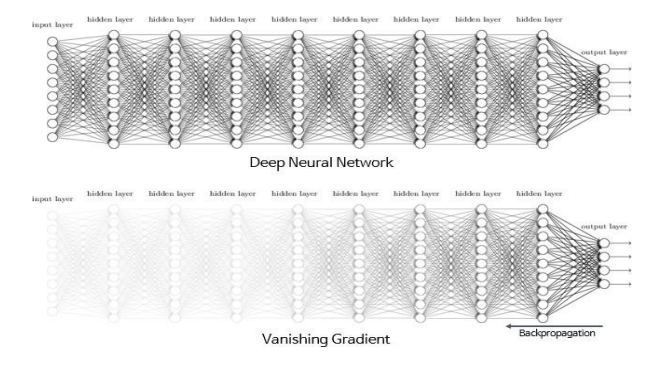

- 경사 폭발(Gradient Exploding): 값이 너무 큰 값 혹은 nand 값이 나오는 경우를 말한다.

<br/>

#### 해결 방법

- 활성함수(Activation function)을 바꾼다
- 가중치 초기화(weight initialization)에 신경쓰자
- 학습률(Learning rate)를 작게 한다: **이 해결책은 Gradient Exploding에만 해당**
- Batch Normalization을 활용한다 => 학습 과정이 굉장히 안정화(stable)된다.

<br/><br/>

<hr/>

### ICS(Internal Covariate Shift)

<br/>

**Internal Covariate Shift**는 경사 소실 및 폭발의 문제를 만드는 원인이다. 먼저 Covariate Shift에 대해 알아보자

<br/>

#### Covariate Shift

- **Covariate Shift**란 Train-set과 Test-set의 분포가 차이가 있기 때문에 독립변수들 간의 공변량(covariate)의 분포가 변화하는 현상을 말한다.

- 전체 데이터셋의 분포를 잘 반영하는 학습/테스트 셋이 아니기 때문에, 표본의 대표성이 떨어져 발생한다.

- 쉽게 생각하자면, 입력과 출력의 분포가 다른 현상이라고 보면 된다.

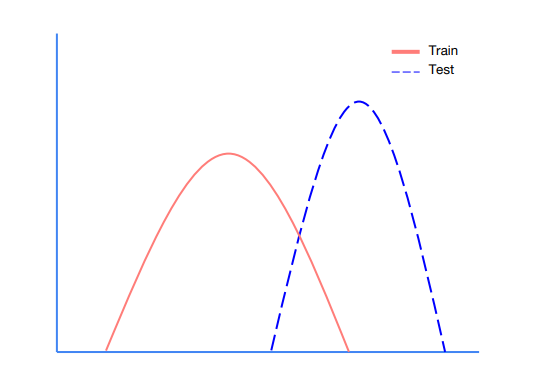

<br/>

#### Internal Covariate Shift

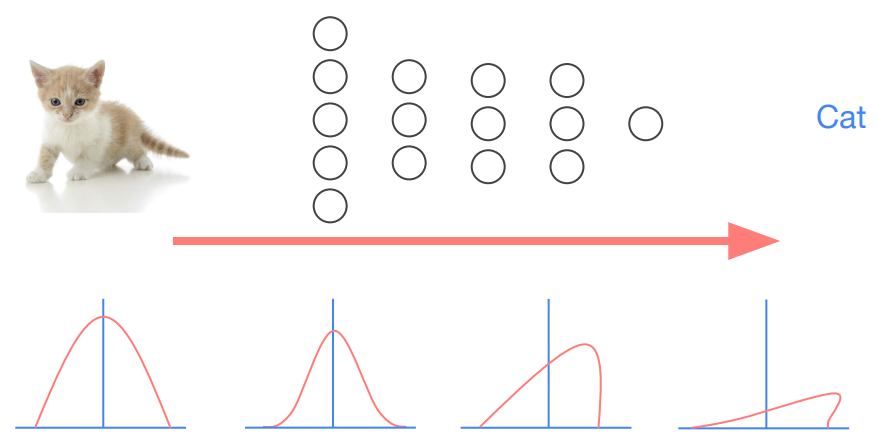

- ICS는 전파와 역전파의 과정에서 발생한다.
- Train-set에는 그래프 맨 왼쪽의 잘 만들어진 분포가지고 있을 것이다.
- 그래프는 각각 Layer를 거치면서 Covariate Shift가 발생해 분포가 점점 휘어져가는 과정을 그린 것이다.
- 입력과 출력, 모델의 문제가 아닌 각 layer에서 발생하는 문제이다.

<br/><br/>

<hr/>

### Batch Normalization

<br/>

- ICS를 해결하기 위해 필요한 것이 **Batch Normalization**이다.
- 각 layer들마다 Normalization을 하는 층(layer)를 둬서 변형된 분포가 나오지 않도록 예방하는 기법이다.
- mini-batch들마다 Normalization을 해주는 것이라고 생각하면 된다.

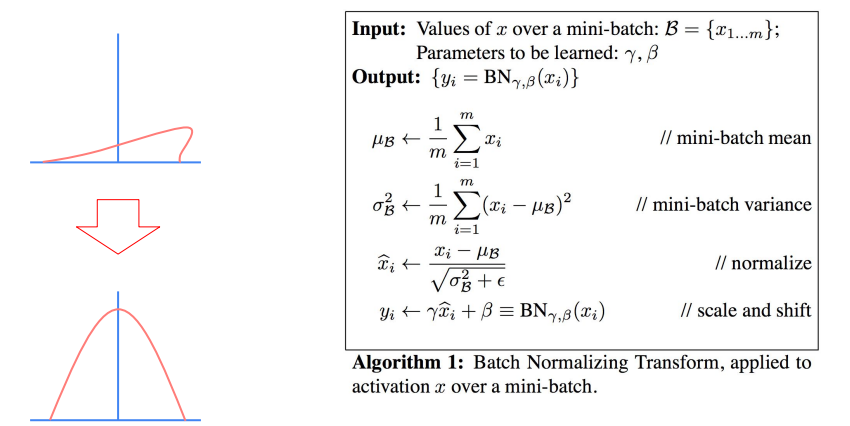

<br/>

- $\epsilon$ 은 0으로 나눠져서 nand값이 나오는 것을 방지하기 위해 사용되는 아주 작은 숫자를 의미한다.
- $\gamma$(감마) 와 $\beta$(베타)는 학습에 관련된 파라미터이다.
- Batch Normalization을 반복하면 activation functoin의 nonlinearity 같은 성질을 잃어버리게 되는데, 이를 완화시켜주는게 $\gamma$ 와 $\beta$이다.
- $\gamma$ 와 $\beta$도 gradient를 계산해 마찬가지로 역전파(back propagation) 학습을 하는 항이다.
- 반면, $\mu$(평균)와 variance(분산)은 학습을 하는 파라미터가 아니다.

<br/><br/>

<hr/>

### Train & eval mode

```python
...
total_batch = len(data_loader)
model.train() # set the model to train mode (dropout=True)
for epoch in range(training_epochs):
    ...
...
```

```python
# Test model and check accuracy
...
with torch.no_grad():
    model.eval() # set the model to evaluation mode (dropout=False)
    ...
...
```

- 위 기능은 Dropout에서 사용하는 기능이지만 Batch Normalization에서도 사용한다.
- 참고자료: [도큐먼트 링크](https://pytorch.org/docs/stable/nn.html?highlight=eval#torch.nn.Module.eval)

<br/>

1. Train-Set을 통해 학습을 시작한다.
2. 학습할 시, sample mean과 sample variance을 계산한다. 이 값을 통해 Normalized된 X hat 값을 계산한다. 그 후 $\gamma$ 와 $\beta$를 이용해 y값을 구한다. 이 때 계산한 sample mean과 sample variance을 따로 저장해둔다. (sample mean= learning mean, sample variance= earning variance)
3. 학습이 끝나면 learning mean과 learning variance를 이용해서 학습된 $\gamma$ 와 $\beta$를 이용해 추론한다(inference)

<br/>

<hr/>

### Code: MNIST BatchNorm

In [11]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [12]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [13]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss.cpu().numpy(), nn_loss.cpu().numpy()])
        train_accs.append([bn_acc.cpu().numpy(), nn_acc.cpu().numpy()])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss.cpu().numpy(), nn_loss.cpu().numpy()])
        valid_accs.append([bn_acc.cpu().numpy(), nn_acc.cpu().numpy()])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.13417(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.18107(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.14621(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.19708(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09796(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.18903(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.12031(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.20696(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09219(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.14206(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.11311(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.16603(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07136(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14226(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.09816(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17967(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [14]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

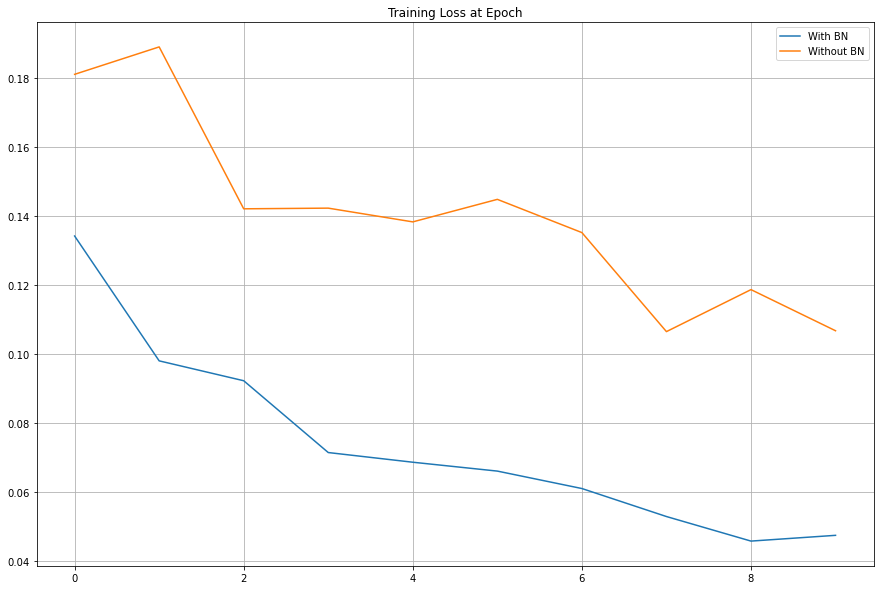

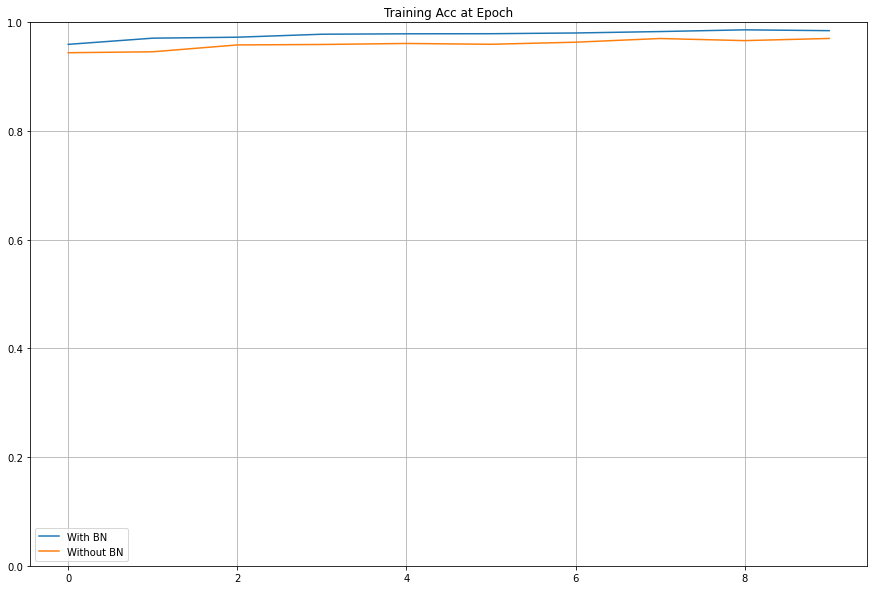

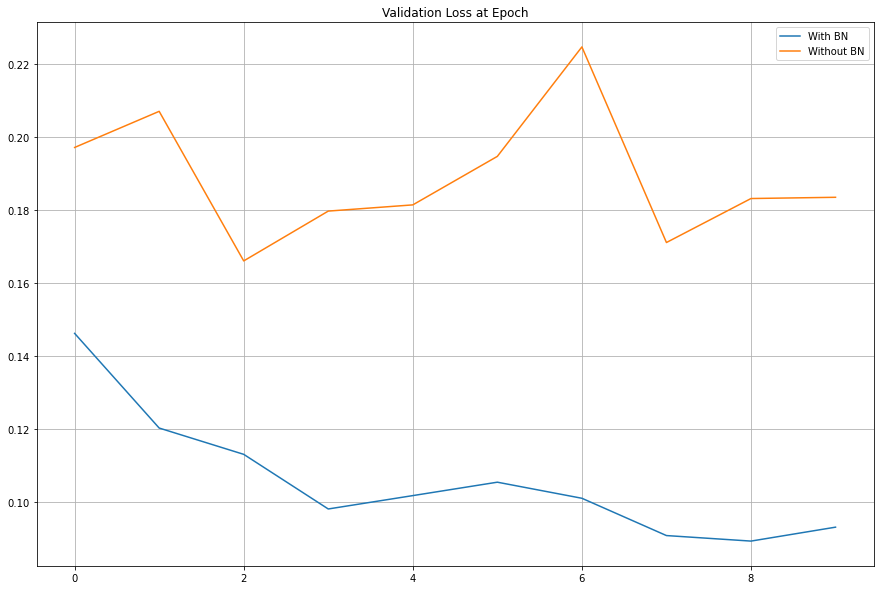

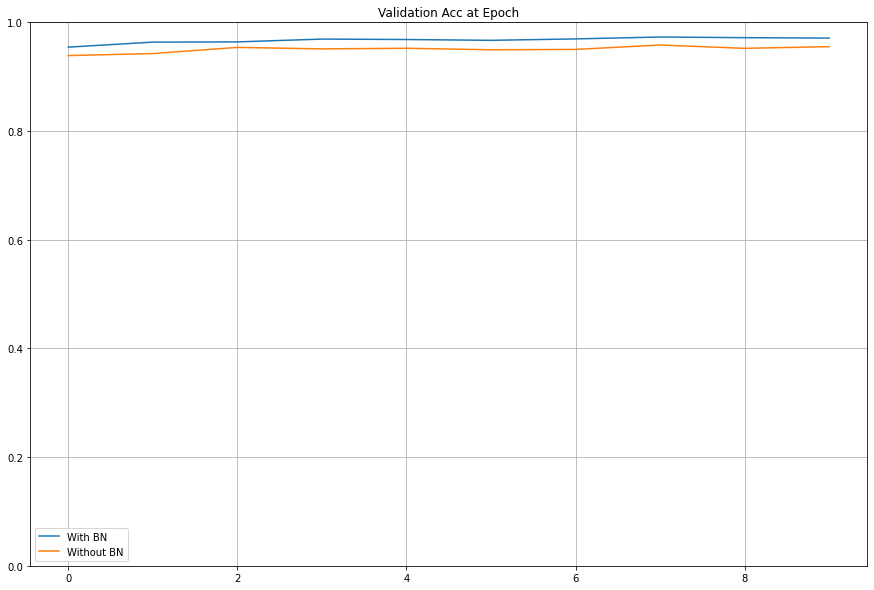

In [15]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')